# Vaccinazioni

Vaccinazioni in Italia.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

In [2]:
eta = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_fasceEta.csv',
    parse_dates=['aggiornamento'],
)

In [3]:
sex = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_sesso.csv',
    parse_dates=['aggiornamento'],
)

In [4]:
cat = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_categoria.csv',
    parse_dates=['aggiornamento'],
)

In [5]:
cat['cat_idx'] = cat.categoria.str.replace('.* - ', '').str.replace(' ', '\n')

In [6]:
reg = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_somministrazioni.csv',
    parse_dates=['aggiornamento'],
)

# Ultimi dati

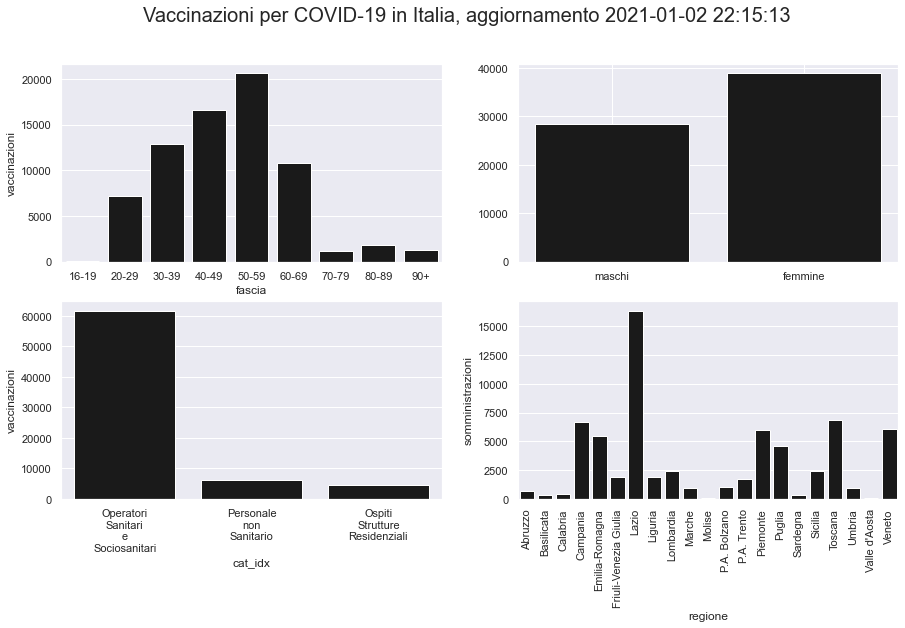

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.barplot(
    data=eta, ax=ax[0,0],
    x='fascia', y='vaccinazioni',
    color='k',
)


ax[0,1].bar('maschi', sex.maschi, color='k')
ax[0,1].bar('femmine', sex.femmine, color='k')

sns.barplot(
    data=cat,
    x='cat_idx',
    y='vaccinazioni',
    color='k',
    ax=ax[1,0]
)

g = sns.barplot(
    data=reg,
    x='regione',
    y='somministrazioni',
    color='k',
    ax=ax[1,1]
)
g.axes.tick_params(axis='x', labelrotation=90)
fig.suptitle(
    f"Vaccinazioni per COVID-19 in Italia, aggiornamento {sex.aggiornamento.max()}",
    fontsize=20,
)
plt.show()

In [8]:
reg_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/somministrazioni.csv',
    parse_dates=['aggiornamento']
)

it_ts = reg_ts.groupby('aggiornamento')[['somministrazioni']].sum()
it_ts.loc[pd.to_datetime('2020-12-28'), 'somministrazioni'] = 0
it_ts.loc[pd.to_datetime('2020-12-29'), 'somministrazioni'] = 8361
it_ts.loc[pd.to_datetime('2020-12-30'), 'somministrazioni'] = 9803
it_ts.loc[pd.to_datetime('2020-12-31'), 'somministrazioni'] = 22789
it_ts.loc[pd.to_datetime('2021-01-01'), 'somministrazioni'] = 45667

for regione in reg_ts.regione.unique():
    reg_ts = reg_ts.append(
        pd.DataFrame({
            'regione': [regione],
            'somministrazioni': [0],
            'percentuale': [0.0],
            'dosiConsegnate': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )

# Totali

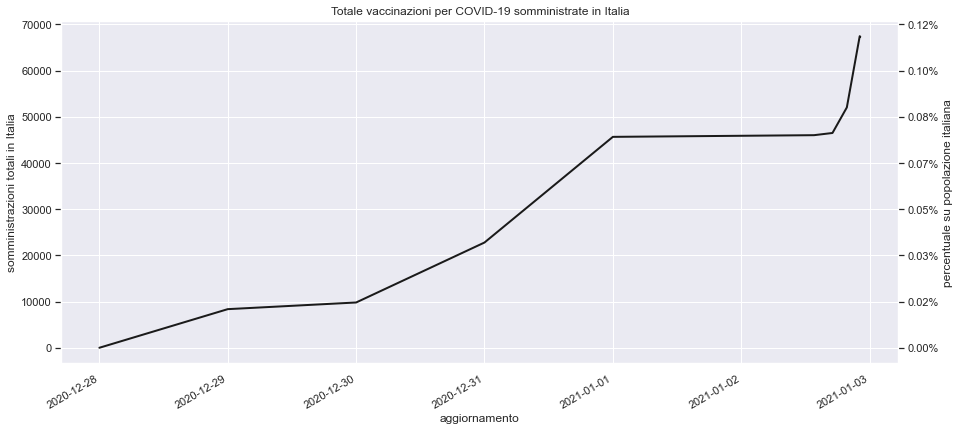

In [9]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
it_ts.plot(
    y='somministrazioni',
    title='Totale vaccinazioni per COVID-19 somministrate in Italia',
    #marker='.', 
    color='k', lw=2,
    legend=False,
    ax=ax
)
ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.2%}" for p in ax1.get_yticks() / 60234639],
    ylabel='percentuale su popolazione italiana'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

plt.show()

# Regioni

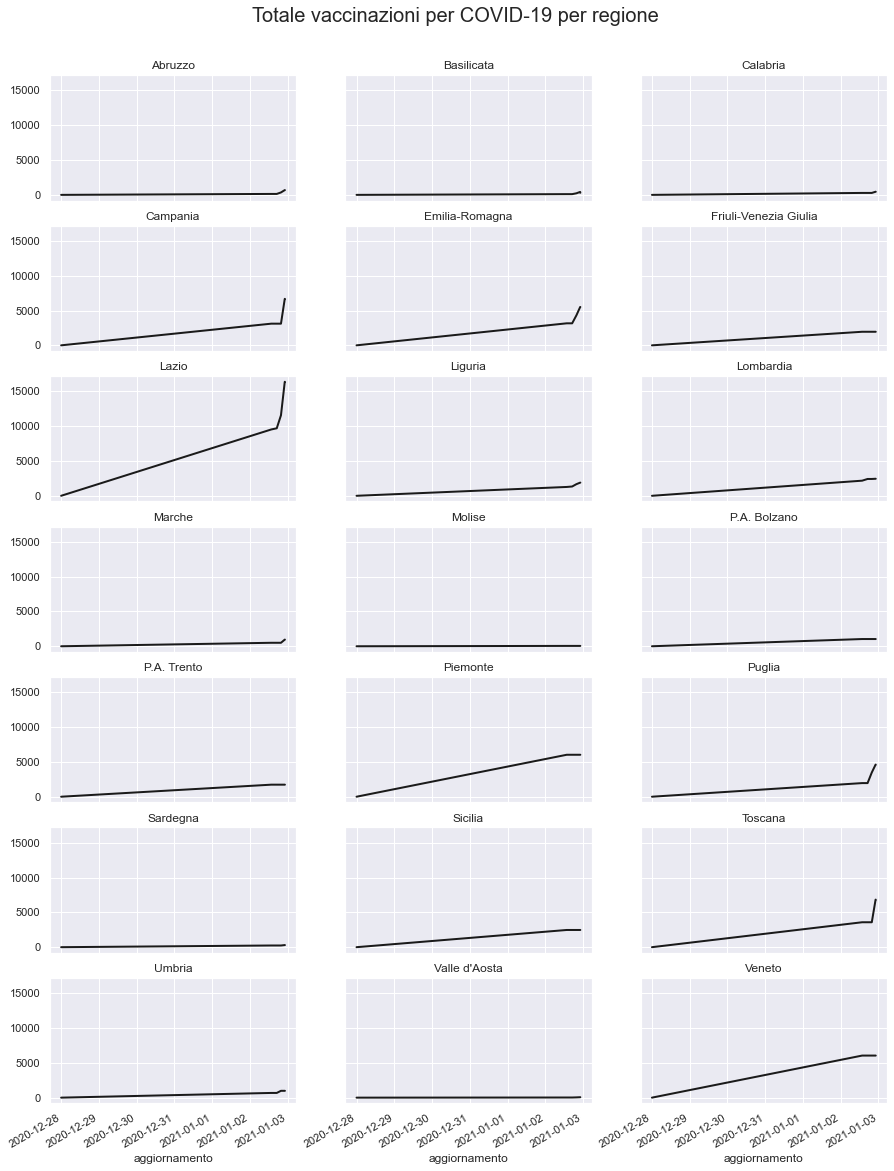

In [10]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg_ts.regione.unique()):
    _ts = reg_ts[reg_ts.regione==regione]
    _ts.plot(
        x='aggiornamento', y='somministrazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
fig.suptitle("Totale vaccinazioni per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

# Età

In [11]:
eta_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/fasceEta.csv',
    parse_dates=['aggiornamento'],
)

In [12]:
for fascia in eta_ts.fascia.unique():
    eta_ts = eta_ts.append(
        pd.DataFrame({
            'fascia': [fascia],
            'vaccinazioni': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )

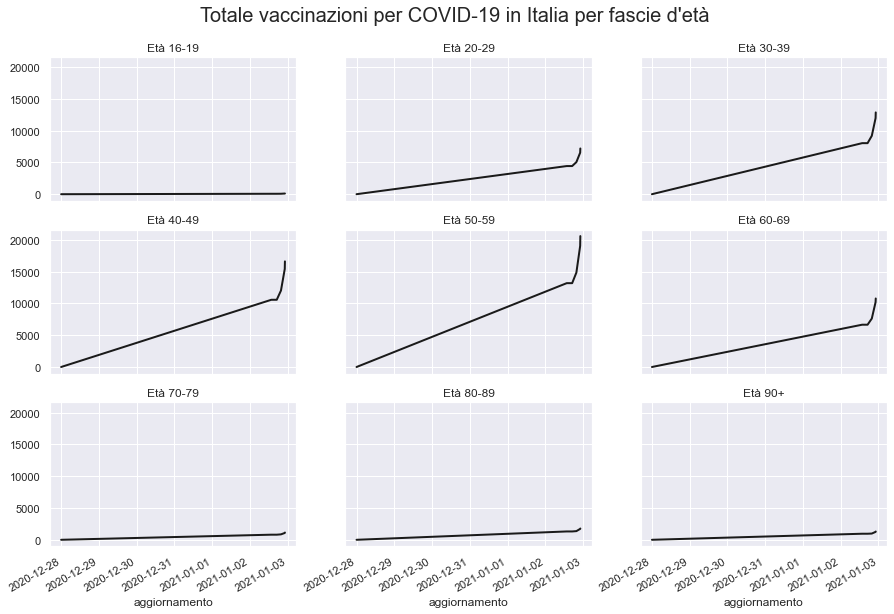

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
for i, fascia in enumerate(eta_ts.fascia.unique()):
    _ts = eta_ts[eta_ts.fascia==fascia]
    _ts.plot(
        x='aggiornamento', y='vaccinazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, 
        legend=False,
        title=f'Età {fascia}'
    )
fig.suptitle("Totale vaccinazioni per COVID-19 in Italia per fascie d'età", fontsize=20, y=.95)
plt.show()

In [14]:
sex_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/sesso.csv',
    parse_dates=['aggiornamento']
)

In [15]:
sex_ts = sex_ts.append(
    pd.DataFrame({
        'maschi': [0],
        'femmine': [0],
        'aggiornamento': [pd.to_datetime('2020-12-28')]
    })
)

# Sesso

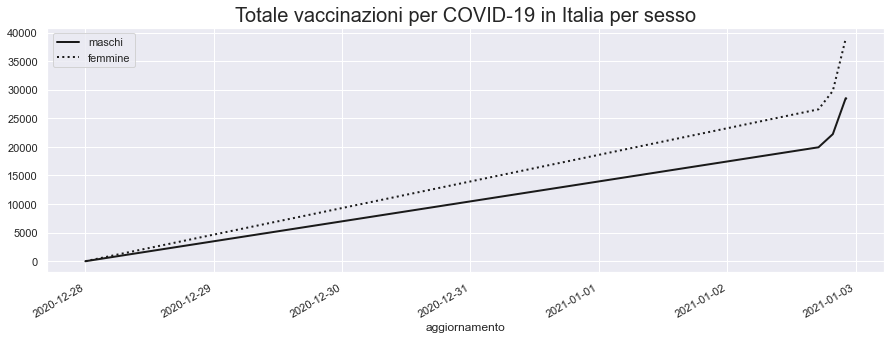

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sex_ts.plot(
    x='aggiornamento', y='maschi',
    #marker='.', ms=2,
    color='k', lw=2, ls='-',
    ax=ax
)
sex_ts.plot(
    x='aggiornamento', y='femmine',
    #marker='.',  ms=2,
    color='k', lw=2, ls=':',
    ax=ax
)
ax.set_title("Totale vaccinazioni per COVID-19 in Italia per sesso", fontsize=20)
plt.show()

In [17]:
cat_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/categoria.csv',
    parse_dates=['aggiornamento']
)

In [18]:
for categoria in cat_ts.categoria.unique():
    cat_ts = cat_ts.append(
        pd.DataFrame({
            'categoria': [categoria],
            'vaccinazioni': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )

# Categoria

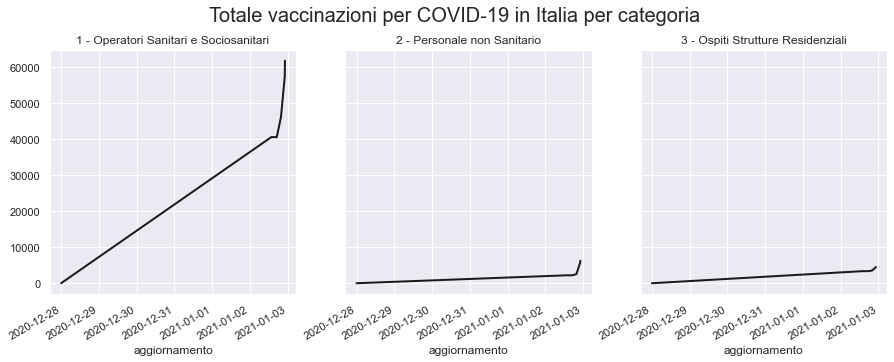

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i, categoria in enumerate(cat_ts.categoria.unique()):
    _ts = cat_ts[cat_ts.categoria==categoria]
    _ts.plot(
        x='aggiornamento', y='vaccinazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, 
        legend=False,
        title=f"{categoria}"
    )
ylim = ax.flat[0].get_ylim()
#ax.flat[0].set(
#    ylim=(0, ylim[1])
#)
fig.suptitle("Totale vaccinazioni per COVID-19 in Italia per categoria", fontsize=20, y=1)
plt.show()